In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import SVG

from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
import os
import cv2
import time
import glob
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import Counter
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
image_size = 224
batch_size = 32
num_classes = 4
channels = 3


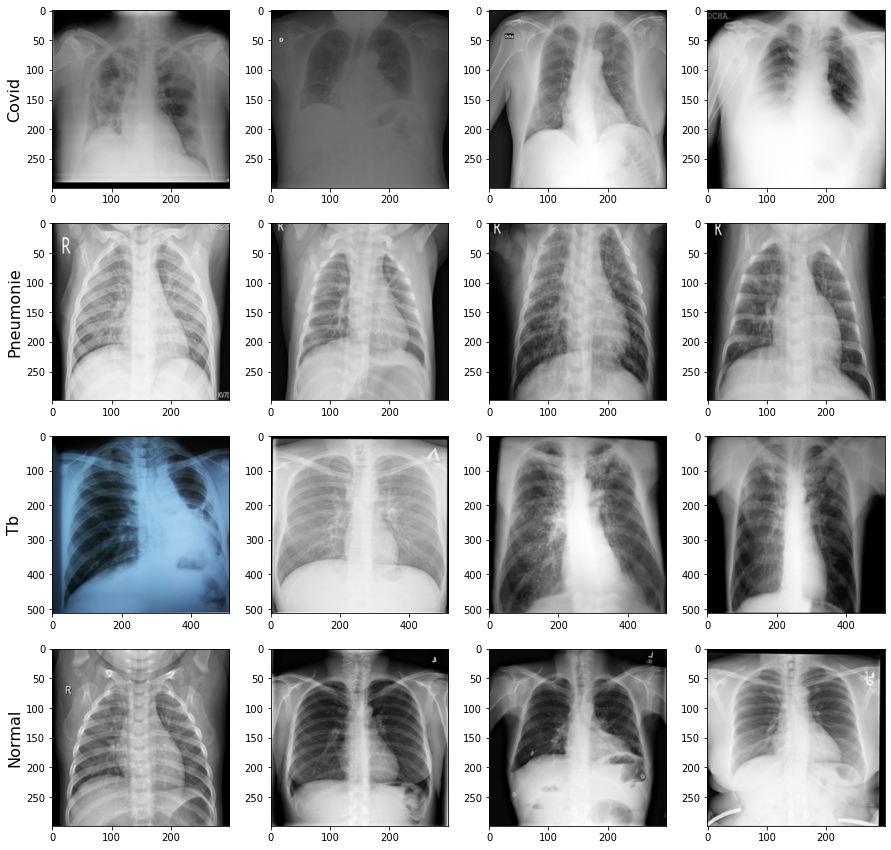

In [4]:
train_path = r'/content/drive/MyDrive/lungs_data/cptn_dataset/Train/'

test_path = r'/content/drive/MyDrive/lungs_data/cptn_dataset/Test/'

classes = ['Covid', 'Pneumonie', 'Tb', 'Normal']


Covid_examples = glob.glob(train_path + 'Covid/*')
Pneu_examples = glob.glob(train_path + 'Pneumonie/*')
Tb_examples = glob.glob(train_path + 'Tb/*')
Normal_examples = glob.glob(train_path + 'Normal/*')
examples = Covid_examples[:4] + Pneu_examples[:4] + Tb_examples[:4] + Normal_examples[:4]

fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 4
for i in range(columns*rows):
    img = plt.imread(examples[i])
    ax = fig.add_subplot(rows, columns, i+1)
    if i%4==0:
        plt.ylabel(classes[int(i/4)], fontsize=16)
    plt.imshow(img, cmap='gray')
plt.show()

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255 ,rotation_range=45,width_shift_range=0.2,
                                   height_shift_range=0.2,horizontal_flip=True, vertical_flip=True,
                                   shear_range=0.2,zoom_range=0.2,fill_mode='reflect', validation_split=0.2)
train_data = train_datagen.flow_from_directory('/content/drive/MyDrive/lungs_data/Train/',
                                               target_size=(image_size, image_size),
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=True
                                              )
validation_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/lungs_data/Train/',target_size=(image_size,image_size),
                                                         batch_size=batch_size,
                                                         class_mode='categorical',
                                                         subset='validation') 
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory("/content/drive/MyDrive/lungs_data/cptn_dataset/Test",target_size=(image_size, image_size),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

Found 9847 images belonging to 4 classes.
Found 1969 images belonging to 4 classes.
Found 2120 images belonging to 4 classes.


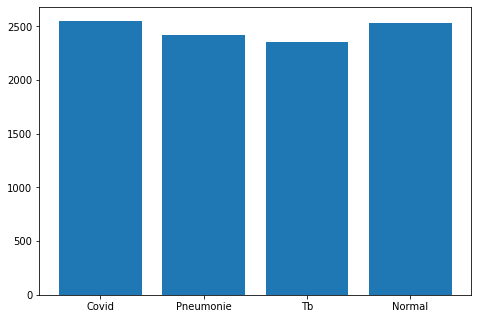

In [8]:

total_covid_samples = len(glob.glob('/content/drive/MyDrive/lungs_data/Train/'+ 'Covid/*'))
total_pneu_samples = len(glob.glob('/content/drive/MyDrive/lungs_data/Train/' + 'Pneumonie/*'))
total_tb_samples = len(glob.glob('/content/drive/MyDrive/lungs_data/Train/' + 'Tb/*'))
total_normal_samples = len(glob.glob('/content/drive/MyDrive/lungs_data/Train/' + 'Normal/*'))

sample_distribution = [total_covid_samples, total_pneu_samples, total_tb_samples, total_normal_samples]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(classes, sample_distribution)
plt.show()

In [ ]:
# Les classes weightes pour que le modèle apprend de tous les classes également
counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))  
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     
print(class_weights)

{0: 1.0, 1: 1.0149377593360995, 2: 1.1366171003717471, 3: 1.1614434947768282}


In [ ]:
#construction des modèles 
vgg16 = VGG16(include_top= False, input_shape= (image_size, image_size, channels), weights= 'imagenet')
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# fine tunnig partiel
model = Sequential()

for layer in vgg16.layers:
    model.add(layer)

for layer in model.layers[:8]:
    layer.trainable= True

model.add(Flatten(input_shape= (4, 4, 512)))
model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

VGG16 Architecture

In [ ]:
model.compile(optimizer= keras.optimizers.Adam(), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
history = model.fit_generator(
    train_generator, 
    epochs = 10,
    steps_per_epoch = train_generator.samples//batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples//100,
    class_weight=class_weights,
    verbose = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
142/142 [==============================] - 36s 241ms/step - loss: 1.4795 - accuracy: 0.3202 - val_loss: 1.1201 - val_accuracy: 0.4602
Epoch 2/10
142/142 [==============================] - 34s 236ms/step - loss: 0.7674 - accuracy: 0.7269 - val_loss: 0.7534 - val_accuracy: 0.7443
Epoch 3/10
142/142 [==============================] - 34s 239ms/step - loss: 0.5441 - accuracy: 0.8128 - val_loss: 0.6277 - val_accuracy: 0.7443
Epoch 4/10
142/142 [==============================] - 34s 236ms/step - loss: 0.4310 - accuracy: 0.8493 - val_loss: 0.4436 - val_accuracy: 0.8466
Epoch 5/10
142/142 [==============================] - 34s 235ms/step - loss: 0.3361 - accuracy: 0.8857 - val_loss: 0.4424 - val_accuracy: 0.8636
Epoch 6/10
142/142 [==============================] - 34s 236ms/step - loss: 0.3034 - accuracy: 0.8999 - val_loss: 0.5560 - val_accuracy: 0.7926
Epoch 7/10
142/142 [==============================] - 34s 241ms/step - loss: 0.2546 - accuracy: 0.9138 - val_loss: 0.5314 - val_ac

In [ ]:
model.save("/content/drive/MyDrive/Vgg1616616.hdf5")

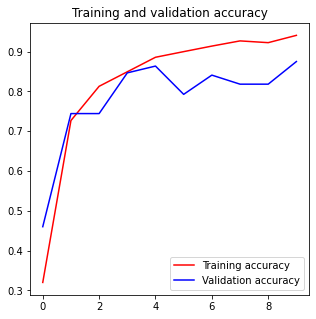

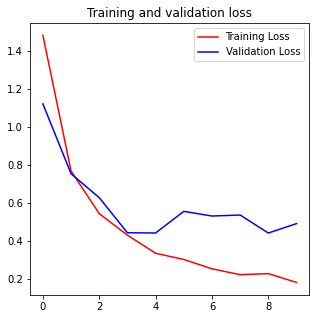

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(5,5))

plt.plot(epochs, acc, 'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize = (5,5))

plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
score = model.evaluate_generator(test_generator,steps = test_generator.samples // 100, verbose= 1) 
print("\n\n")
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


21/21 [==============================] - 4s 165ms/step - loss: 0.1603 - accuracy: 0.9405



Test Loss: 0.16032607853412628
Test accuracy: 0.9404761791229248


In [ ]:
pred_datagen = ImageDataGenerator(rescale=1./255)

pred_generator = pred_datagen.flow_from_directory("/content/OCT2017/test",target_size=(image_size, image_size),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  shuffle = False)  

Found 1000 images belonging to 4 classes.


In [ ]:
y_pred = model.predict(test_generator,steps = 100)
Y_test = test_generator.classes[test_generator.index_array]
Y_pred = np.argmax(y_pred, axis=-1)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

--------------------
| Confusion Matrix |
--------------------

 [[174 141 177  84]
 [140 174 156 112]
 [144 167 185 106]
 [ 98  95 100  67]]


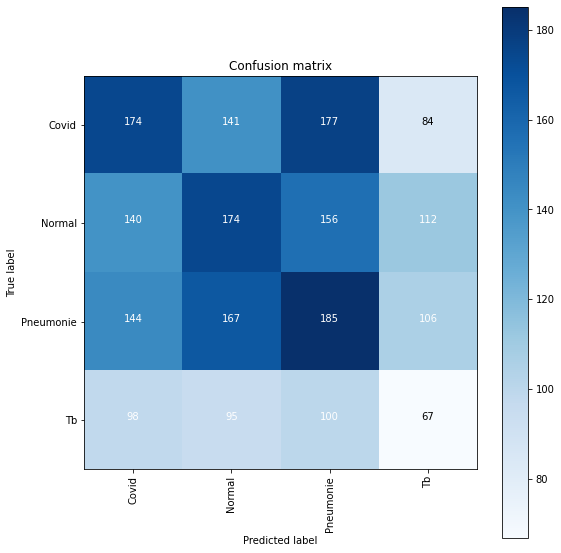

In [ ]:
import itertools
cm = confusion_matrix(Y_test, Y_pred)
 
print('--------------------')
print('| Confusion Matrix |')
print('--------------------')
print('\n {}'.format(cm))
        
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(cm, classes=['Covid','Normal','Pneumonie','Tb'], normalize=False, 
                      title='Confusion matrix', cmap = plt.cm.Blues)
plt.show()